Made using Google colab https://colab.research.google.com/

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To check no. of classes in train folder of dataset:

In [43]:
len(os.listdir('/content/drive/MyDrive/PlantDiseaseDataset/New Plant Diseases Dataset(Augmented)/train'))

38

# Pre-processing the dataset

In [44]:
# Data augmentation for training images
train_datagen = ImageDataGenerator(zoom_range = 0.5, shear_range = 0.3, horizontal_flip = True)

# Preprocessing for validation images
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)


In [45]:
# Creating training and validation data generators from the specified directory with data augmentation.

train = train_datagen.flow_from_directory(directory = "/content/drive/MyDrive/PlantDiseaseDataset/New Plant Diseases Dataset(Augmented)/train",
                                          target_size = (256, 256),
                                          batch_size = 32)

val = val_datagen.flow_from_directory(directory = "/content/drive/MyDrive/PlantDiseaseDataset/New Plant Diseases Dataset(Augmented)/valid",
                                          target_size = (256, 256),
                                          batch_size = 32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


Now we are done loading the dataset

# Visualizing some of our data

In [46]:
t_img, label = train.next() # next() is used to load up the next batch of images for training

t_img.shape

(32, 256, 256, 3)


t_img has 32 images of 256 x 256 and 3 channel per image(RGB)

In [47]:
def plotImage(img_arr, label):
    for im, l in zip(img_arr, label):
        plt.figure(figsize = (5,5))
        plt.imshow(im/255)
        plt.show()


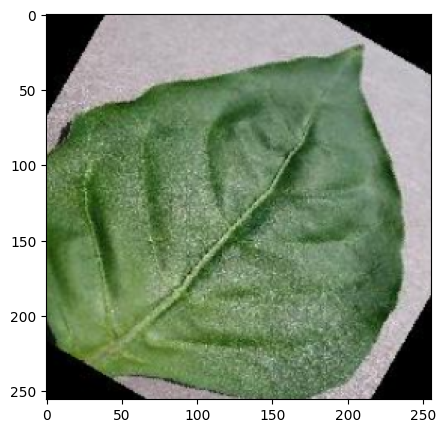

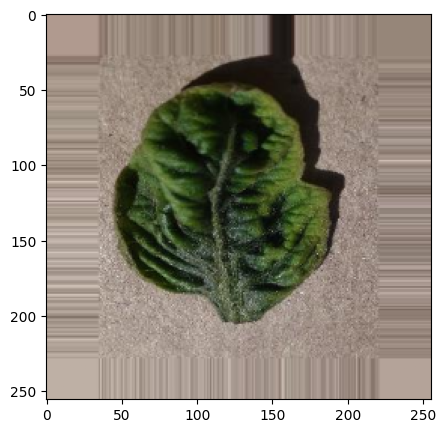

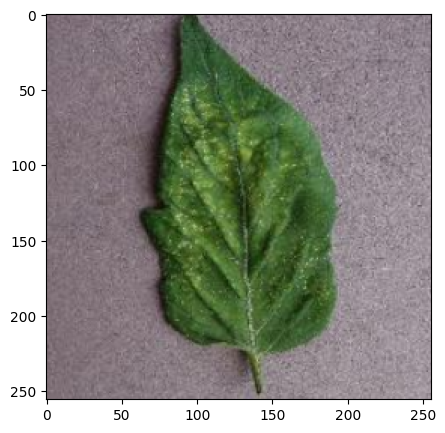

In [48]:
plotImage(t_img[:3], label[:3])

# Building the model

In [49]:
import keras
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19

In [50]:
#Creating a VGG19 base model
#VGG19 is a pre-defined CNN used for image classification
base_model = VGG19(input_shape=(256,256,3), include_top = False)

In [51]:
# Freeze all layers in the base model to prevent further training.
for layer in base_model.layers:
    layer.trainable=False

In [52]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [53]:
# Flatten the output of model to prepare for fully connected layers.
X = Flatten()(base_model.output)

# Add a fully connected layer with 38 units for classification using softmax activation.
X = Dense(units=38, activation='softmax')(X)

# Create our final model by combining the model and the new fully connected layer.
model = Model(base_model.input, X)


In [54]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [55]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

# Early stopping and model checkpoints

In [58]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Early stopping: Stop training if validation accuracy does not improve by at least 0.01 for 3 consecutive epochs.
es = EarlyStopping(monitor = "val_accuracy",
                   min_delta = 0.01,
                   patience = 3,
                   verbose=1)

# Model checkpoint: Save the best model based on validation accuracy during training.
mc = ModelCheckpoint(filepath="best_model.h5",
                     monitor = "val_accuracy",
                     min_delta = 0.01,
                     patience = 3,
                     verbose = 1,
                     save_best_only = True)

# Combine early stopping and model checkpoint callbacks.
cb = [es, mc]

# Train the model on the training data using the specified callbacks.
his = model.fit(train,
                steps_per_epoch = 25,
                epochs = 50,
                verbose = 1,
                callbacks = cb,
                validation_data = val,
                validation_steps = 25)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 13.0757 - accuracy: 0.6112
Epoch 1: val_accuracy improved from -inf to 0.58594, saving model to best_model.h5
25/25 [==============================] - 36s 1s/step - loss: 13.0757 - accuracy: 0.6112 - val_loss: 10.9159 - val_accuracy: 0.5859
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 12.7871 - accuracy: 0.6388
Epoch 2: val_accuracy improved from 0.58594 to 0.59473, saving model to best_model.h5
25/25 [==============================] - 25s 996ms/step - loss: 12.7871 - accuracy: 0.6388 - val_loss: 12.0000 - val_accuracy: 0.5947
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 12.3565 - accuracy: 0.6875
Epoch 3: val_accuracy did not improve from 0.59473
25/25 [==============================] - 27s 1s/step - loss: 12.3565 - accuracy: 0.6875 - val_loss: 14.7365 - val_accuracy: 0.5869
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 13.3012 - accuracy: 0.6700
Epoc

Vizualizing the accuracy and loss of trained model(for reference):

In [ ]:
# h = his.history
# h.keys()

In [ ]:
# plt.plot(h['accuracy'])
# plt.plot(h['val_accuracy'], c = 'red')
# plt.title("acc vs val_acc")
# plt.xlim(0, 7)
# plt.ylim(0.4, 1)
# plt.legend(['accuracy', 'val_accuracy'])
# plt.show()

In [ ]:
# plt.plot(h['loss'])
# plt.plot(h['val_loss'], c = 'red')
# plt.title("loss vs val_loss")
# # plt.xlim(0, 7)
# # plt.ylim(0.4, 1)
# plt.legend(['loss', 'val_loss'])
# plt.show()

In [59]:
from keras.models import load_model

# Load the pre-trained model from the "best_model.h5" file.
model = load_model("best_model.h5")

# Evaluate the model's accuracy on the validation data
# The "evaluate" method returns the loss value and the metrics specified during model compilation
# In this case, we are interested in the accuracy, which is at index 1 in the returned list
val_accuracy = model.evaluate(val)[1]

# Print the accuracy of the model on the validation data
print(f'The accuracy of the model on the validation data is {val_accuracy * 100:.2f}%')


550/550 [==============================] - 116s 210ms/step - loss: 10.3616 - accuracy: 0.6624
The accuracy of your model on the validation data is 66.24%


In [60]:
# Creating a dictionary 'ref' that maps class indices to their corresponding class names from the 'train' data
ref = dict(zip(list(train.class_indices.values()), list(train.class_indices.keys())))

In [61]:
def prediction(path):
  # Load the image from the given path and resize it to 256x256 pixels
  img = load_img(path, target_size=(256, 256))

  # Convert the image to a NumPy array to prepare it for prediction
  i = img_to_array(img)

  # Preprocess the image using the same preprocessing applied during training
  im = preprocess_input(i)

  # Expand the dimensions of the preprocessed image to create a batch of one image
  img = np.expand_dims(im, axis=0)

  # Use the trained model to predict the class of the image
  pred = np.argmax(model.predict(img))

  # Print the predicted class name based on the mapping from 'ref'
  print(f'The image belongs to {ref[pred]}')


Dataset contains images for Apple, Cherry, Corn, Grape, Peach, Pepper, Potato, Strawberry, Tomato

In [62]:
path = "/content/drive/MyDrive/PlantDiseaseDataset/test/TomatoYellowCurlVirus5.JPG"
prediction(path)

1/1 [==============================] - 1s 816ms/step
The image belongs to Tomato___Tomato_Yellow_Leaf_Curl_Virus
